In [1]:
import pandas as pd 
import numpy as np

df = pd.read_csv('sample/gridly_feedback.csv')
df.head()

,Customer Name,Customer feedback,Feedback code,Feedback main theme,Feedback Secondary theme,Feedback type,Feedback submitted
0,Scopely,"TM fuzzy matching, including 101% (order match...",TM fuzzy matching,"[""Translation memory""]",NaN,Feature request,2020-09-13T17:00:00Z
1,Scopely,Glossaries (terminology) support,Glossary support,"[""Glossary/Term""]",NaN,Feature request,2020-09-13T17:00:00Z
2,Scopely,Be able to export and import translations in m...,One-file multi-language export,"[""Export""]",NaN,Feature request,2020-09-13T17:00:00Z
3,Scopely,Be able to read/write from a specific branch v...,Read/write from specific branch via API,"[""Branch""]",API,Feature request,2020-09-13T17:00:00Z
4,Scopely,"More elaborate comments system, with a overvie...",Comments overview section,"[""Comments""]",NaN,Feature request,2020-09-13T17:00:00Z


In [2]:
drop_list = ['Feedback code', 'Feedback main theme', 'Feedback Secondary theme', 'Feedback submitted']
df = df.drop(columns=drop_list)
df = df.dropna()
df['feedback_id'] = df['Feedback type'].factorize()[0]
feedback_id_df = df[['Feedback type', 'feedback_id']].drop_duplicates().sort_values('feedback_id')
feedback_to_id = dict(feedback_id_df.values)
id_to_feedback = dict(feedback_id_df[['feedback_id', 'Feedback type']].values)
df.head()

,Customer Name,Customer feedback,Feedback type,feedback_id
0,Scopely,"TM fuzzy matching, including 101% (order match...",Feature request,0
1,Scopely,Glossaries (terminology) support,Feature request,0
2,Scopely,Be able to export and import translations in m...,Feature request,0
3,Scopely,Be able to read/write from a specific branch v...,Feature request,0
4,Scopely,"More elaborate comments system, with a overvie...",Feature request,0


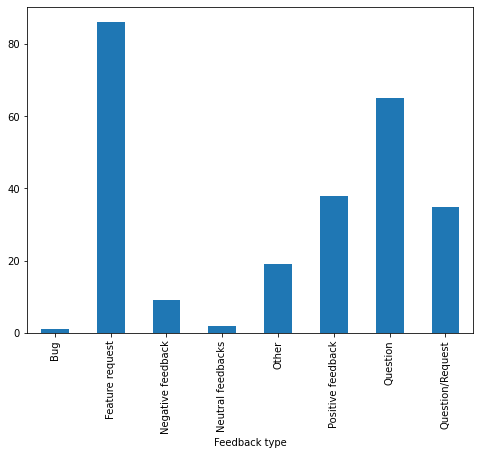

In [3]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('Feedback type')['Customer feedback'].count().plot.bar(ylim=0)
plt.show()

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
features = tfidf.fit_transform(df['Customer feedback']).toarray()
labels = df['feedback_id']
features.shape

(255, 74)

In [5]:
from sklearn.feature_selection import chi2
import numpy as np
N = 2
for feedbackType, feedback_id in sorted(feedback_to_id.items()):
  features_chi2 = chi2(features, labels == feedback_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(feedbackType))
  print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-N:])))

# 'Bug':
  . Most correlated unigrams:
. column
. columns
  . Most correlated bigrams:
. google sheets
. does gridly
# 'Feature request':
  . Most correlated unigrams:
. want
. support
  . Most correlated bigrams:
. google sheets
. version control
# 'Negative feedback':
  . Most correlated unigrams:
. data
. upload
  . Most correlated bigrams:
. google sheets
. does gridly
# 'Neutral feedbacks':
  . Most correlated unigrams:
. column
. json
  . Most correlated bigrams:
. google sheets
. does gridly
# 'Other':
  . Most correlated unigrams:
. demo
. use
  . Most correlated bigrams:
. does gridly
. google sheets
# 'Positive feedback':
  . Most correlated unigrams:
. liked
. interested
  . Most correlated bigrams:
. does gridly
. version control
# 'Question':
  . Most correlated unigrams:
. does
. file
  . Most correlated bigrams:
. version control
. google sheets
# 'Question/Request':
  . Most correlated unigrams:
. asked
. self
  . Most correlated bigrams:
. google sheets
. does gridly


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
X_train, X_test, y_train, y_test = train_test_split(df['Customer feedback'], df['Feedback type'], random_state = 0)
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [7]:
print(clf.predict(count_vect.transform(["""TM fuzzy matching, including 101% (order matching)"""])))

['Feature request']


In [8]:
import pickle

pickleVariable = {"model": clf, "count_vect": count_vect}
with open('saved_steps.pkl', 'wb') as file:
    pickle.dump(pickleVariable, file)
    
with open('saved_steps.pkl', 'rb') as file:
    pickleVariable = pickle.load(file)

model = pickleVariable["model"]
count_vect = pickleVariable["count_vect"]

In [9]:
print(model.predict(count_vect.transform(["""TM fuzzy matching, including 101% (order matching)"""])))

['Feature request']
